In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torchvision import transforms as T
import pickle
import numpy as np
from copy import deepcopy
from mmcv import Config
from mmcv.runner import load_checkpoint
from mmcv.cnn.bricks.plugin import build_plugin_layer
import projects.mmdet3d_plugin
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet3d.core import bbox3d2result
import matplotlib.pyplot as plt
from projects.mmdet3d_plugin.constants import *
from tools.viz_utils import *
torch.set_printoptions(sci_mode=False)

In [2]:
tens_to_pil = T.ToPILImage()
def denormalize_img(data, cfg):
    img_norm_mean = np.array(cfg.img_norm_cfg['mean'])
    img_norm_std = np.array(cfg.img_norm_cfg['std'])
    raw_imgs = data['img'][0][0].permute(0, 2, 3, 1).cpu().numpy()
    raw_imgs = raw_imgs * img_norm_std + img_norm_mean
    return raw_imgs

def get_topk_enc_output_proposals(enc_out):
    enc_bbox_preds = enc_out['bbox_preds_enc']
    enc_cls_preds = enc_out['cls_scores_enc']
    enc_repr_cls = enc_cls_preds.max(-1).values
    topq_inds = torch.topk(enc_repr_cls, 644, dim=1)[1]
    topq_cls = torch.gather(enc_cls_preds, 1,
                            topq_inds.unsqueeze(-1).repeat(1, 1, enc_cls_preds.size(-1)))
    topq_coords = torch.gather(enc_bbox_preds, 1, 
                            topq_inds.unsqueeze(-1).repeat(1,1,enc_bbox_preds.size(-1)))
    return topq_cls, topq_coords

In [3]:
checkpoint_path = "./work_dirs/from_hpc/cmdha_12pt_anchorref_updatepos_4gpu16bs/iter_147672.pth"
cfg = Config.fromfile("./projects/configs/execution/cmdha_12pt_anchorref_updatepos_nocp_1gpu2bs.py")
## add debug args
cfg['debug_args']['debug_modules'] = cfg['debug_modules']
cfg.model.setdefault("debug_args", cfg['debug_args'])
cfg.model.pretrained=None
model = build_detector(
        cfg.model,
        test_cfg=cfg.get('test_cfg'))
model.init_weights()
model=model.cuda()

checkpoint = load_checkpoint(model, checkpoint_path)
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
model.eval()

/home/student/anaconda3/envs/streampetr_exp/lib/python3.8/site-packages/mmdet/models/backbones/resnet.py:401: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
2024-02-29 00:10:46,098 - mmcv - INFO - 
0.attentions.0.sampling_offsets.weight - torch.Size([256, 256]): 
The value is the same before and after calling `init_weights` of ModuleList  
 
2024-02-29 00:10:46,099 - mmcv - INFO - 
0.attentions.0.sampling_offsets.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of ModuleList  
 
2024-02-29 00:10:46,100 - mmcv - INFO - 
0.attentions.0.attention_weights.weight - torch.Size([128, 256]): 
The value is the same before and after calling `init_weights` of ModuleList  
 
2024-02-29 00:10:46,100 - mmcv - INFO - 
0.attentions.0.attention_weights.bias - torch.Size([128]): 
The value is the same before and after calling `init_weights` of ModuleList  
 


{0: './experiments/depth_coords/MDHA/depth_map_176x64.pkl', 1: './experiments/depth_coords/MDHA/depth_map_88x32.pkl', 2: './experiments/depth_coords/MDHA/depth_map_44x16.pkl', 3: './experiments/depth_coords/MDHA/depth_map_22x8.pkl'}
CIRCULAR DEFORMABLE ATTENION RESET
initialized encoder
CIRCULAR DEFORMABLE ATTENION RESET
CIRCULAR DEFORMABLE ATTENION RESET
CIRCULAR DEFORMABLE ATTENION RESET
CIRCULAR DEFORMABLE ATTENION RESET
CIRCULAR DEFORMABLE ATTENION RESET
CIRCULAR DEFORMABLE ATTENION RESET
initialized pts bbox head


2024-02-29 00:10:46,398 - mmcv - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

2024-02-29 00:10:46,410 - mmcv - INFO - initialize FPN with init_cfg {'type': 'Xavier', 'layer': 'Conv2d', 'distribution': 'uniform'}
2024-02-29 00:10:46,428 - mmcv - INFO - 
lateral_convs.0.conv.weight - torch.Size([256, 256, 1, 1]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2024-02-29 00:10:46,429 - mmcv - INFO - 
lateral_convs.0.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FPN  
 
2024-02-29 00:10:46,429 - mmcv - INFO - 
lateral_convs.1.conv.weight - torch.Size([256, 512, 1, 1]): 
XavierInit: gain=1, distribution=uniform, bias=0 
 
2024-02-29 00:10:46,430 - mmcv - INFO - 
lateral_convs.1.conv.bias - torch.Size([256]): 
The value is the same before and after calling `init_weights` of FPN  
 
2024-02-29 00:10:46,430 - mmcv - INFO - 
lateral_convs.2.conv.weight - torch.Siz

load checkpoint from local path: ./work_dirs/from_hpc/cmdha_12pt_anchorref_updatepos_4gpu16bs/iter_147672.pth


Petr3D(
  (pts_bbox_head): StreamPETRHead(
    (loss_cls): FocalLoss()
    (loss_bbox): L1Loss()
    (memory_embed): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (pseudo_reference_points): Embedding(256, 3)
    (query_embedding): Sequential(
      (0): Linear(in_features=384, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=256, bias=True)
    )
    (time_embedding): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (ego_pose_pe): MLN(
      (reduce): Sequential(
        (0): Linear(in_features=180, out_features=256, bias=True)
        (1): ReLU()
      )
      (gamma): Linear(in_features=256, out_features=256, bias=True)
      (beta): Linear(in_features=256, out_features=256, bias=True)
      (ln): LayerNorm((256,), eps

In [4]:
def plot_top_k_outputs(d, cfg, k=20, plot_encoder=False, thickness=2):
    raw_imgs = denormalize_img(d, cfg)
    out = model(return_loss=False, viz=True, **d)
    topq_cls, topq_coords = get_topk_enc_output_proposals(out[1])
    enc_pred_viz = dict(
        all_cls_scores = [topq_cls],
        all_bbox_preds = [topq_coords]
    )
    d0_img_metas = d['img_metas'][0]
    enc_bbox_list = model.pts_bbox_head.get_bboxes(enc_pred_viz, d0_img_metas)
    enc_bbox_results = [
        bbox3d2result(bboxes, scores, labels)
        for bboxes, scores, labels in enc_bbox_list
    ]
    enc_output_proposals_lidarbboxs = enc_bbox_results[0]['boxes_3d']
    enc_output_proposals = torch.cat([enc_output_proposals_lidarbboxs.gravity_center,
                                    enc_output_proposals_lidarbboxs.tensor[..., 3:]], dim=-1)
    lidar2imgs = d['lidar2img'][0][0]
    final_dec_out = out[0][0]['pts_bbox']['boxes_3d']
    final_dec_out_box = torch.cat([final_dec_out.gravity_center,
                                   final_dec_out.tensor[..., 3:]], dim=-1)
    plt.figure(figsize=(20,10))
    plt.axis("off")
    to_plot = enc_output_proposals if plot_encoder else final_dec_out_box
    plt.imshow(draw_lidar_bbox3d(to_plot[:k], raw_imgs, lidar2imgs, thickness=thickness))

In [5]:
for i in range(290, 300):
    with open(f"./experiments/test_data/data_iter_{i}.pkl", "rb") as f:
        d0 = pickle.load(f)

In [6]:
with open("./experiments/test_data/data_iter_341.pkl", "rb") as f:
    d0 = pickle.load(f)

In [7]:
CAM_MAPPING = {
    "CAM_FRONT": 0,
    "CAM_FRONT_RIGHT": 1,
    "CAM_BACK_RIGHT": 2,
    "CAM_BACK": 3,
    "CAM_BACK_LEFT": 4, 
    "CAM_FRONT_LEFT": 5
}

In [8]:
lidar2img_reordered = []
img_reordered=[]
l2i = d0['lidar2img'][0][0]
img = d0['img'][0][0]
for cam in ["CAM_FRONT_LEFT", "CAM_FRONT", "CAM_FRONT_RIGHT",
            "CAM_BACK_LEFT", "CAM_BACK", "CAM_BACK_RIGHT"]:
    lidar2img_reordered.append(l2i[CAM_MAPPING[cam]])
    img_reordered.append(img[CAM_MAPPING[cam]])
lidar2img_reordered = torch.stack(lidar2img_reordered)
img_reordered = torch.stack(img_reordered)

d_reordered = deepcopy(d0)
d_reordered['img'] = [img_reordered[None]]
d_reordered['lidar2img'] = [[lidar2img_reordered]]

/home/student/anaconda3/envs/streampetr_exp/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/student/anaconda3/envs/streampetr_exp/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divid

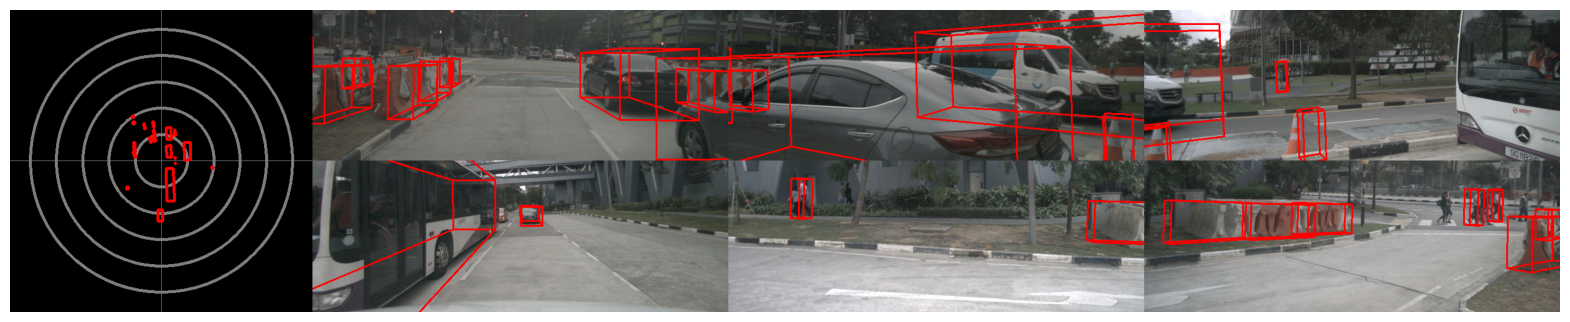

In [9]:
plot_top_k_outputs(deepcopy(d0), cfg, k=20)

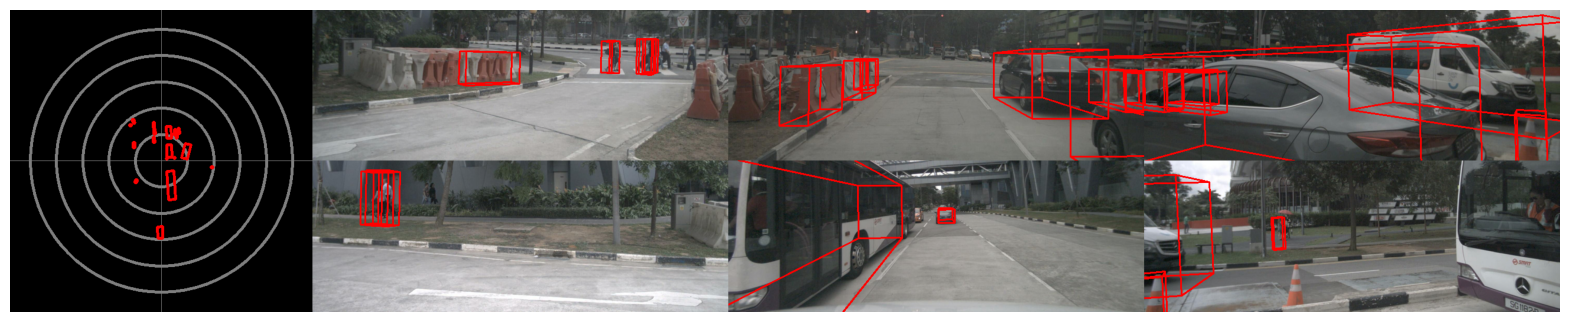

In [11]:
plot_top_k_outputs(deepcopy(d_reordered), cfg, k=20)

In [ ]:
plt.

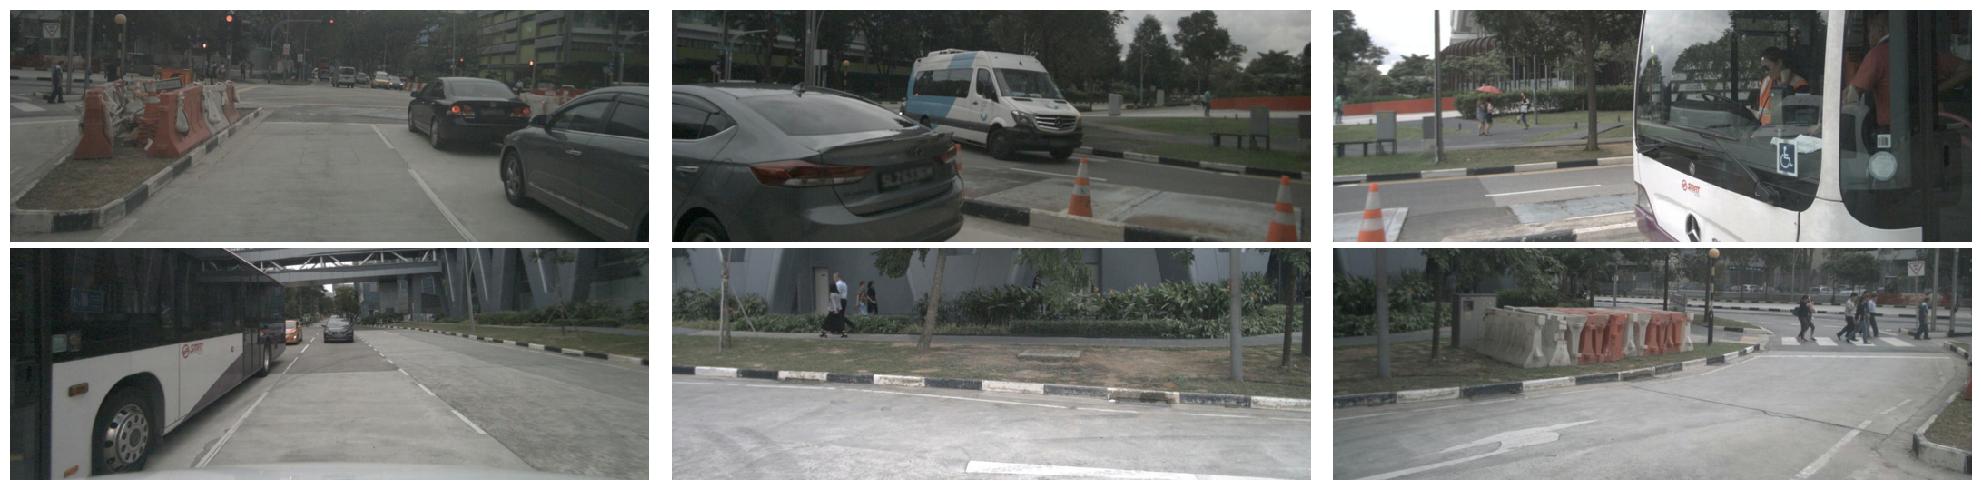

In [6]:
raw_imgs = denormalize_img(d0, cfg)
fig, axs = plt.subplots(2, 3, figsize=(20,5))
i=0
for row in range(2):
    for col in range(3):
        axs[row][col].imshow(raw_imgs[i].astype(np.uint8), interpolation="nearest")
        axs[row][col].axis("off")
        i += 1
fig.tight_layout()

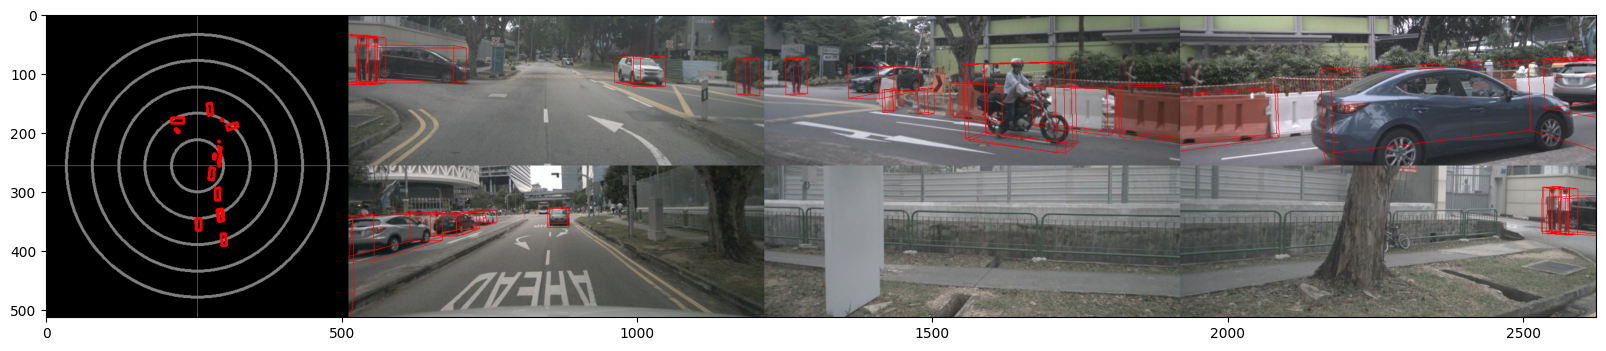

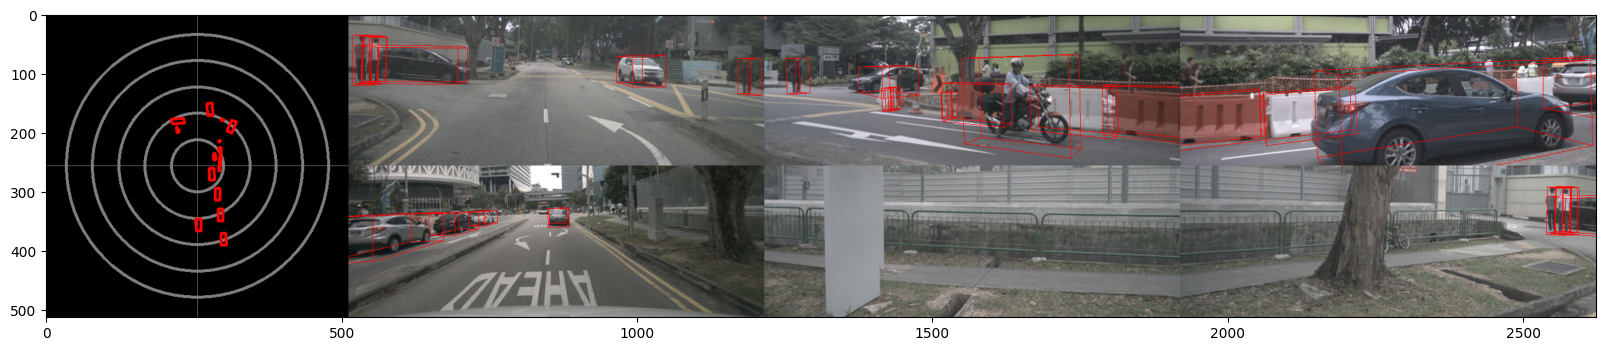

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(draw_lidar_bbox3d(final_dec_out_box[:20], raw_imgs, lidar2imgs))

In [39]:
enc_output_proposals_lidarbboxs

LiDARInstance3DBoxes(
    tensor([[     8.8202,      2.9677,     -2.0980,  ...,     -0.1579,
              0.0005,     -0.0004],
        [     0.4712,    -22.3867,     -2.1612,  ...,      1.5918,
             -0.1476,      8.5514],
        [     7.7706,    -10.8154,     -2.1755,  ...,     -1.5362,
              0.0001,     -0.0006],
        ...,
        [    -0.9556,    -50.8507,     -2.2855,  ...,      1.6220,
              0.0004,      0.1348],
        [    -5.5199,    -43.1900,     -2.0537,  ...,      2.6721,
             -0.0002,      0.0006],
        [    17.5631,    -27.0678,     -2.4164,  ...,      1.7122,
             -0.0002,      0.3540]], grad_fn=<CloneBackward>))

In [40]:
from mmdet3d.core.bbox.structures import LiDARInstance3DBoxes

In [56]:
enc_output_proposals_lidarbboxs.tensor.shape

torch.Size([300, 9])

In [57]:
LiDARInstance3DBoxes.overlaps(enc_output_proposals_lidarbboxs[0], enc_output_proposals_lidarbboxs[8]).item()

0.0

In [75]:
overlaps = []
target = 6
for i in range(300):
    if i == target: continue
    overlap = LiDARInstance3DBoxes.overlaps(enc_output_proposals_lidarbboxs[target], enc_output_proposals_lidarbboxs[i]).item()
    overlaps.append(overlap)
    # if overlap > max_overlap:
    #     max_overlap = overlap

In [76]:
max(overlaps)

0.3562498688697815

In [50]:
enc_output_proposals_lidarbboxs[0]

LiDARInstance3DBoxes(
    tensor([[     8.8202,      2.9677,     -2.0980,      0.4729,      2.0063,
              1.0545,     -0.1579,      0.0005,     -0.0004]],
       grad_fn=<CloneBackward>))

In [53]:
enc_output_proposals_lidarbboxs[8]

LiDARInstance3DBoxes(
    tensor([[     8.3834,      0.7118,     -2.0187,      0.4788,      2.0335,
              1.0916,     -3.0659,     -0.0003,     -0.0007]],
       grad_fn=<CloneBackward>))

In [34]:
enc_output_proposals.shape

torch.Size([300, 9])